# GMaps on Android

The goal of this experiment is to test out GMaps on a Pixel device running Android and collect results.

In [1]:
from conf import LisaLogging
LisaLogging.setup()

2017-03-07 11:58:33,971 INFO    : root         : Using LISA logging configuration:
2017-03-07 11:58:33,972 INFO    : root         :   /home/vagrant/lisa/logging.conf


In [2]:
%pylab inline

import json
import os

# Support to access the remote target
import devlib
from env import TestEnv

# Import support for Android devices
from android import Screen, Workload

# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy

import pandas as pd
import sqlite3

from IPython.display import display

Populating the interactive namespace from numpy and matplotlib


In [3]:
def experiment():
    # Configure governor
    target.cpufreq.set_all_governors('sched')
    
    # Get workload
    wload = Workload.getInstance(te, 'GMaps')
        
    # Run GMaps
    wload.run(out_dir=te.res_dir,
          collect="ftrace",
          location_search="London British Museum",
          swipe_count=10)
        
    # Dump platform descriptor
    te.platform_dump(te.res_dir)


# Test environment setup

For more details on this please check out **examples/utils/testenv_example.ipynb**.

**devlib** requires the ANDROID_HOME environment variable configured to point to your local installation of the Android SDK. If you have not this variable configured in the shell used to start the notebook server, you need to run a cell to define where your Android SDK is installed or specify the ANDROID_HOME in your target configuration.

In case more than one Android device are conencted to the host, you must specify the ID of the device you want to target in **my_target_conf**. Run **adb devices** on your host to get the ID.

In [4]:
# Setup target configuration
my_conf = {

    # Target platform and board
    "platform"     : 'android',
    "board"        : 'pixel',
    
    # Device serial ID
    # Not required if there is only one device connected to your computer
    "device"       : "HT67M0300128",
    
    # Android home
    # Not required if already exported in your .bashrc
    "ANDROID_HOME" : "/home/vagrant/lisa/tools/",

    # Folder where all the results will be collected
    "results_dir" : "Gmaps_example",

    # Define devlib modules to load
    "modules"     : [
        'cpufreq'       # enable CPUFreq support
    ],

    # FTrace events to collect for all the tests configuration which have
    # the "ftrace" flag enabled
    "ftrace"  : {
         "events" : [
            "sched_switch",
            "sched_wakeup",
            "sched_wakeup_new",
            "sched_overutilized",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
            "sched_load_waking_task",
            "cpu_capacity",
            "cpu_frequency",
            "cpu_idle",
            "sched_tune_config",
            "sched_tune_tasks_update",
            "sched_tune_boostgroup_update",
            "sched_tune_filter",
            "sched_boost_cpu",
            "sched_boost_task",
            "sched_energy_diff"
         ],
         "buffsize" : 100 * 1024,
    },

    # Tools required by the experiments
    "tools"   : [ 'trace-cmd', 'taskset'],
}

In [5]:
# Initialize a test environment using:
te = TestEnv(my_conf, wipe=False)
target = te.target

2017-03-07 11:58:34,695 INFO    : TestEnv      : Using base path: /home/vagrant/lisa
2017-03-07 11:58:34,696 INFO    : TestEnv      : Loading custom (inline) target configuration
2017-03-07 11:58:34,697 INFO    : TestEnv      : External tools using:
2017-03-07 11:58:34,697 INFO    : TestEnv      :    ANDROID_HOME: /home/vagrant/lisa/tools/
2017-03-07 11:58:34,698 INFO    : TestEnv      :    CATAPULT_HOME: /home/vagrant/lisa/tools/catapult
2017-03-07 11:58:34,699 INFO    : TestEnv      : Devlib modules to load: ['bl', 'cpufreq']
2017-03-07 11:58:34,699 INFO    : TestEnv      : Connecting Android target [HT67M0300128]
2017-03-07 11:58:34,700 INFO    : TestEnv      : Connection settings:
2017-03-07 11:58:34,700 INFO    : TestEnv      :    {'device': 'HT67M0300128'}
2017-03-07 11:58:34,816 INFO    : android      : ls command is set to ls
2017-03-07 11:58:35,276 INFO    : TestEnv      : Initializing target workdir:
2017-03-07 11:58:35,277 INFO    : TestEnv      :    /data/local/tmp/devlib-t

# Workload execution

In [6]:
results = experiment()

2017-03-07 11:58:38,241 INFO    : Workload     : Supported workloads available on target:
2017-03-07 11:58:38,242 INFO    : Workload     :   youtube, gmaps
2017-03-07 11:58:39,292 INFO    : Screen       : Set brightness: 0%
2017-03-07 11:58:40,713 INFO    : Screen       : Force manual orientation
2017-03-07 11:58:40,714 INFO    : Screen       : Set orientation: PORTRAIT
2017-03-07 11:58:43,978 INFO    : GMaps        : FTrace START
2017-03-07 11:58:45,948 INFO    : GMaps        : Opening GMaps to [geo:0,0?q=London+British+Museum]
2017-03-07 11:59:28,839 INFO    : GMaps        : FTrace STOP
2017-03-07 11:59:52,547 INFO    : Screen       : Set brightness: AUTO
2017-03-07 11:59:52,548 INFO    : Screen       : Set orientation: AUTO


# Trace analysis

For more information on this please check **examples/trace_analysis/TraceAnalysis_TasksLatencies.ipynb**.

In [7]:
# Load traces in memory (can take several minutes)
platform_file = os.path.join(te.res_dir, 'platform.json')

with open(platform_file, 'r') as fh:
    platform = json.load(fh)

trace_file = os.path.join(te.res_dir, 'trace.dat')
trace = Trace(trace_file, my_conf['ftrace']['events'], platform, normalize_time=False)

2017-03-07 12:03:21,641 INFO    : Trace        : Platform clusters verified to be Frequency coherent


In [8]:
# Find exact task name & PID
for pid, name in trace.getTasks().iteritems():
    if "GLRunner" in name:
        glrunner = {"pid" : pid, "name" : name}
        
        
print("name=\"" + glrunner["name"] + "\"" + " pid=" + str(glrunner["pid"]))

name="GLRunner 484" pid=19308


# EAS-induced wakeup latencies

In this example we are looking at a specific task : **GLRunner**. **GLRunner** is a very CPU-heavy task, and is also boosted (member of the top-app group) in EAS, which makes it an interesting task to study.

To study the behaviour of **GLRunner**, we'll be looking at the wakeup decisions of the scheduler. We'll be looking for times at which the task took "too long" to wake up, i.e it was runnable and had to wait some time to actually be run. In our case that latency treshold is (arbitrarily) set to 1ms.

We're also on the lookout for when the task has been moved from one CPU to another. Depending on several parameters (kernel version, boost values, etc), the task could erroneously be switched to another CPU which could induce wakeup latencies.

Finally, we're only interested in scheduling decisions made by EAS, so we'll only be looking at wakeup latencies that occured when the system was not overutilized, i.e EAS was enabled.

In [9]:
# Helper functions to pinpoint issues

def find_prev_cpu(trace, taskname, time):
    sdf = trace.data_frame.trace_event('sched_switch')
    sdf = sdf[sdf.prev_comm == taskname]
    sdf = sdf[sdf.index <= time]
    sdf = sdf.tail(1)
    
    wdf = trace.data_frame.trace_event('sched_wakeup')
    wdf = wdf[wdf.comm == taskname]
    wdf = wdf[wdf.index <= time]
    # We're looking for the previous wake event,
    # not the one related to the wake latency
    wdf = wdf.tail(2)
    
    stime = sdf.index[0]
    wtime = wdf.index[1]
    
    if stime > wtime:
        res = wdf["target_cpu"].values[0]
    else:
        res = sdf["__cpu"].values[0]
    
    return res
    
def find_next_cpu(trace, taskname, time):
    wdf = trace.data_frame.trace_event('sched_wakeup')
    wdf = wdf[wdf.comm == taskname]
    wdf = wdf[wdf.index <= time].tail(1)
    return wdf["target_cpu"].values[0]

def trunc(value, precision):
    offset = pow(10, precision)
    res = int(value * offset)
    return float(res) / offset

In [10]:
# Look for latencies > 1 ms
df = trace.data_frame.latency_wakeup_df(glrunner["pid"])
df = df[df.wakeup_latency > 0.001]

# Load times at which system was overutilized (EAS disabled)
ou_df = trace.data_frame.overutilized()

2017-03-07 12:03:53,563 INFO    : Analysis     : Parsing sched_switch states assuming kernel v3.18
2017-03-07 12:03:53,564 INFO    : Analysis     : Parsing sched_switch states assuming kernel v3.18
2017-03-07 12:03:53,565 INFO    : Analysis     : Parsing sched_switch states assuming kernel v3.18
2017-03-07 12:03:53,582 INFO    : Analysis     : Parsing sched_switch states assuming kernel v3.18


In [11]:
# Find which wakeup latencies were induced by EAS
# Times to look at will be saved in a times.txt file

eas_latencies = []
times_file = te.res_dir + "/times.txt"
!touch {times_file}

for time, cols in df.iterrows():
    # Check if cpu was over-utilized (EAS disabled)
    ou_row = ou_df[:time].tail(1)
    if ou_row.empty:
        continue
        
    was_eas = ou_row.iloc[0, 1] < 1.0
    
    if (was_eas):
        toprint = "{:.1f}ms @ {}".format(cols[0] * 1000, trunc(time, 5))            
        next_cpu = find_next_cpu(trace, glrunner["name"], time)
        prev_cpu = find_prev_cpu(trace, glrunner["name"], time)
        
        if (next_cpu != prev_cpu):
            toprint += " [CPU SWITCH]"
        print toprint
        
        eas_latencies.append([time, cols[0]])
        !echo {toprint} >> {times_file}
        
        

1.1ms @ 26863.66521 [CPU SWITCH]
1.5ms @ 26865.66686
2.5ms @ 26866.69789
12.0ms @ 26872.9786
2.8ms @ 26884.95497
1.0ms @ 26885.95852 [CPU SWITCH]
2.0ms @ 26895.22396 [CPU SWITCH]
1.1ms @ 26896.19532


# Traces visualisation

For more information on this please check **examples/trace_analysis/TraceAnalysis_TasksLatencies.ipynb**.

Here each latency is plotted in order to double-check that it was truly induced by an EAS decision. In LISA, the latency plots have a red background when the system is overutilized, which shouldn't be the case here.

2017-03-07 12:03:58,243 INFO    : Analysis     : Found:  2517 WAKEUP latencies
2017-03-07 12:03:58,302 INFO    : Analysis     : Found: 15435 PREEMPT latencies
2017-03-07 12:03:58,304 INFO    : Analysis     : Total: 17952 latency events
2017-03-07 12:03:58,308 INFO    : Analysis     : 97.2 % samples below 1 [ms] threshold
2017-03-07 12:04:14,282 INFO    : Analysis     : Found:  2517 WAKEUP latencies
2017-03-07 12:04:14,461 INFO    : Analysis     : Found: 15435 PREEMPT latencies
2017-03-07 12:04:14,463 INFO    : Analysis     : Total: 17952 latency events
2017-03-07 12:04:14,467 INFO    : Analysis     : 97.2 % samples below 1 [ms] threshold
2017-03-07 12:04:31,485 INFO    : Analysis     : Found:  2517 WAKEUP latencies
2017-03-07 12:04:31,801 INFO    : Analysis     : Found: 15435 PREEMPT latencies
2017-03-07 12:04:31,802 INFO    : Analysis     : Total: 17952 latency events
2017-03-07 12:04:31,808 INFO    : Analysis     : 97.2 % samples below 1 [ms] threshold
2017-03-07 12:04:46,868 INFO   

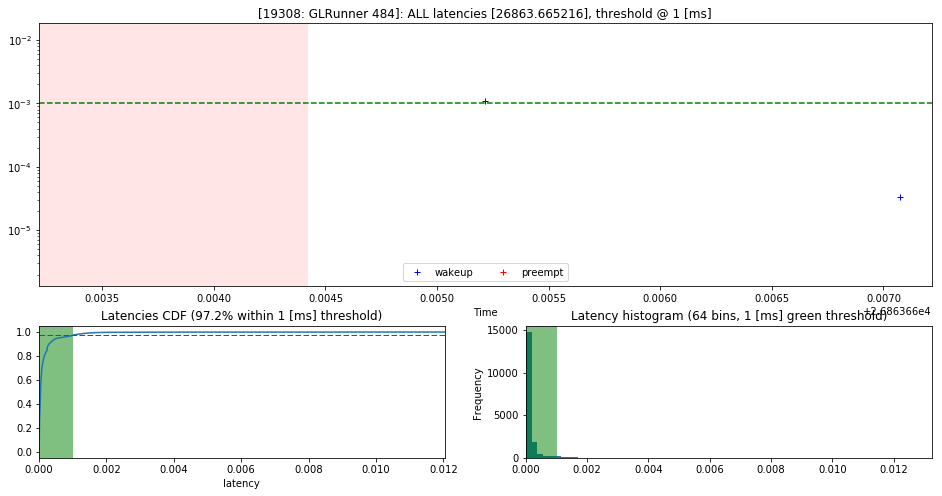

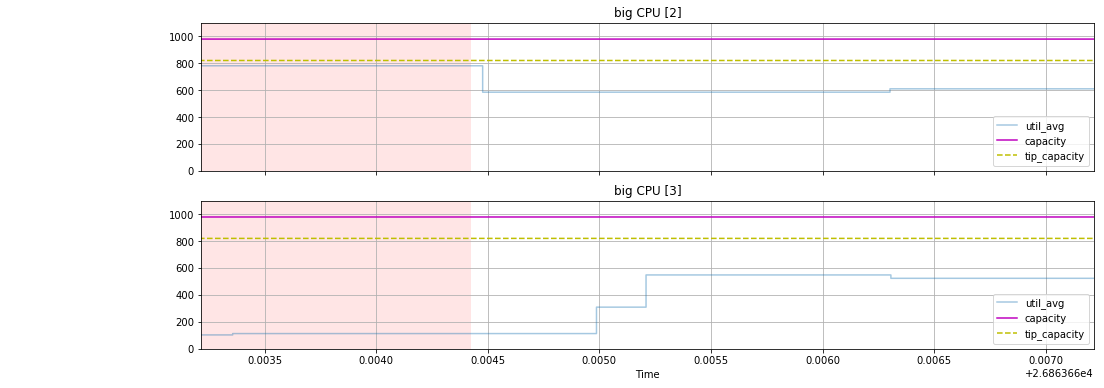

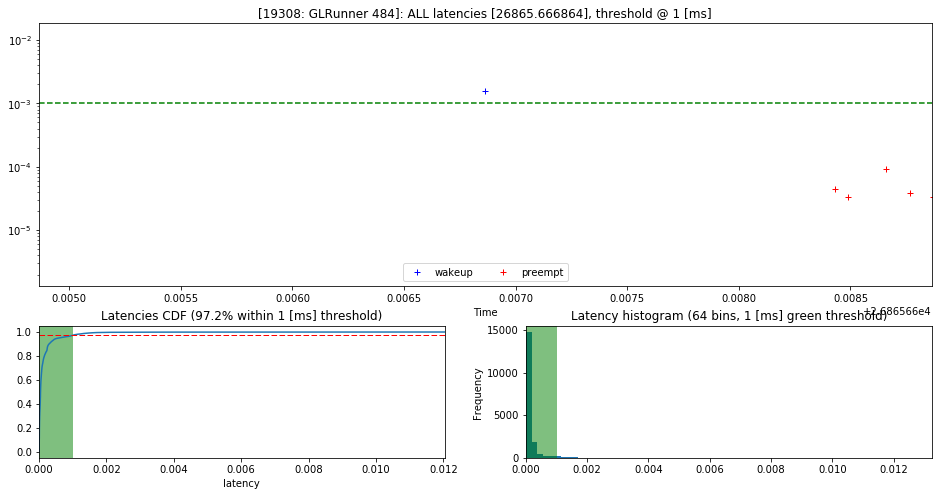

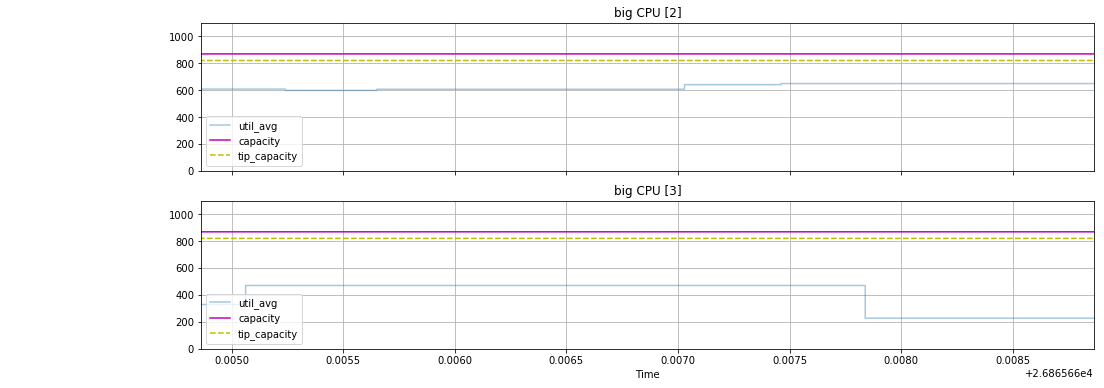

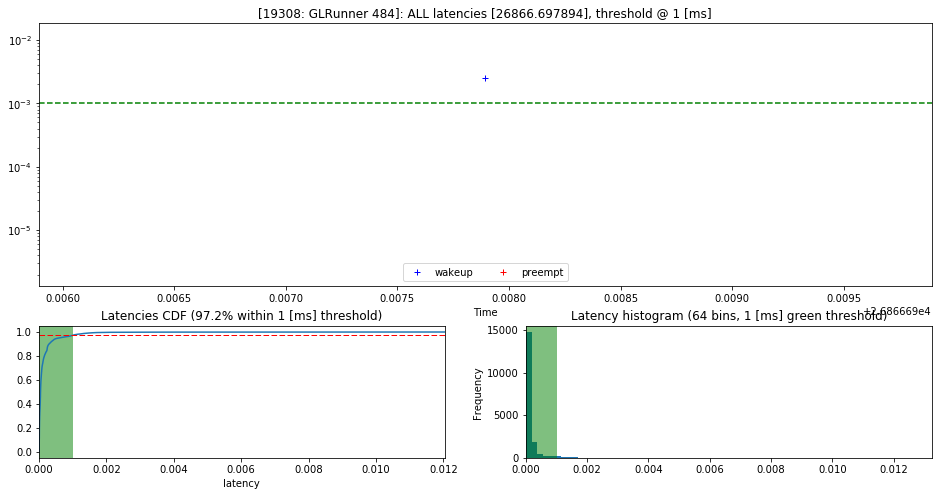

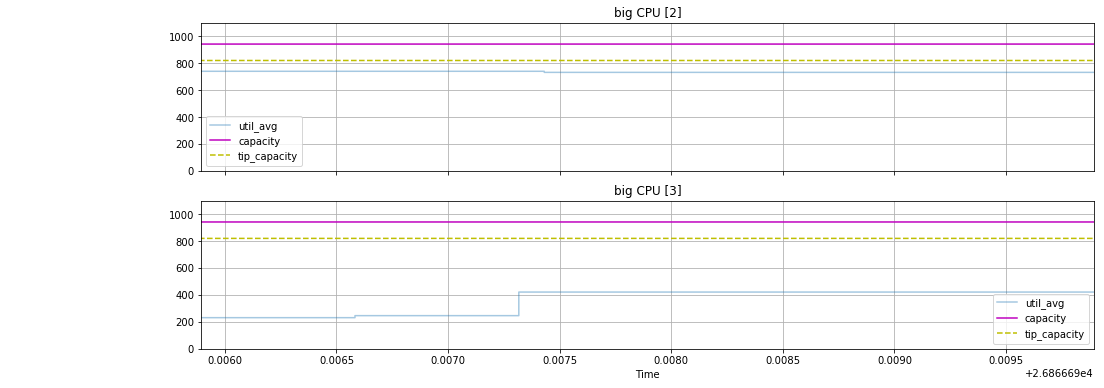

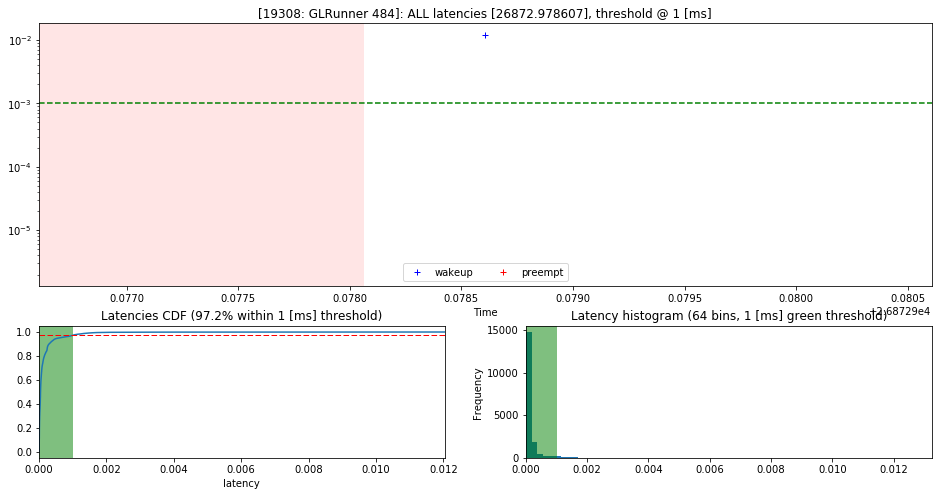

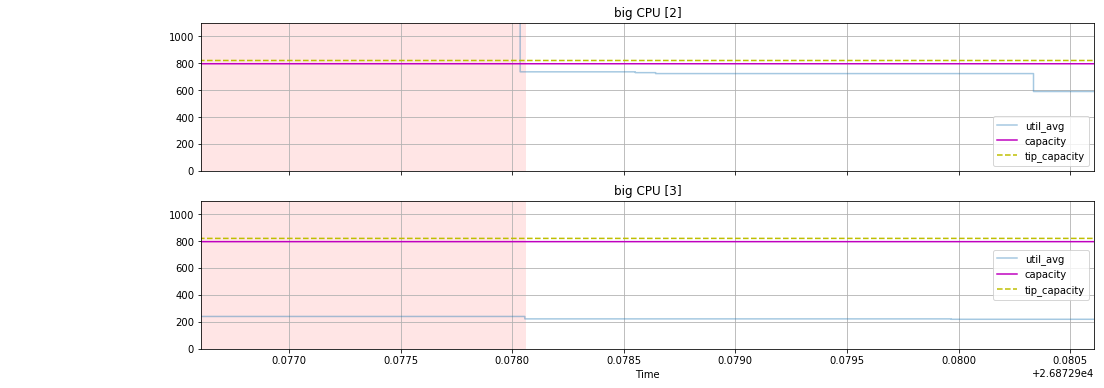

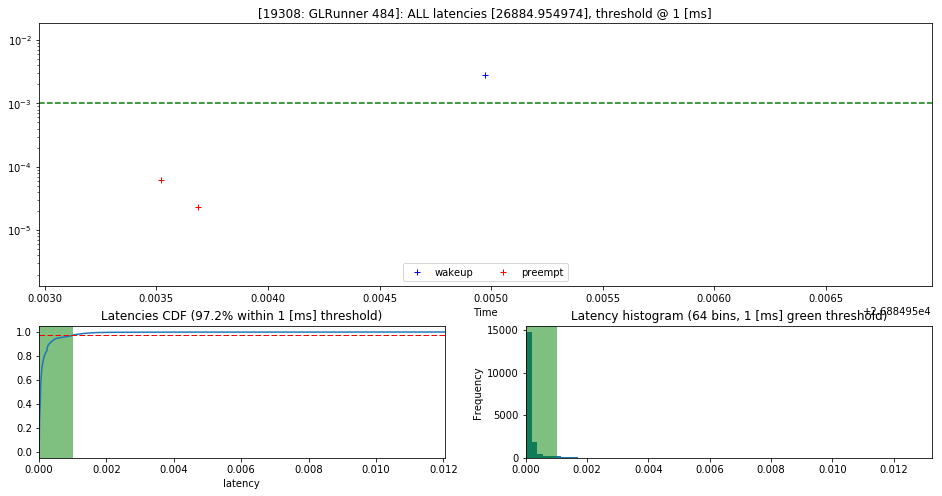

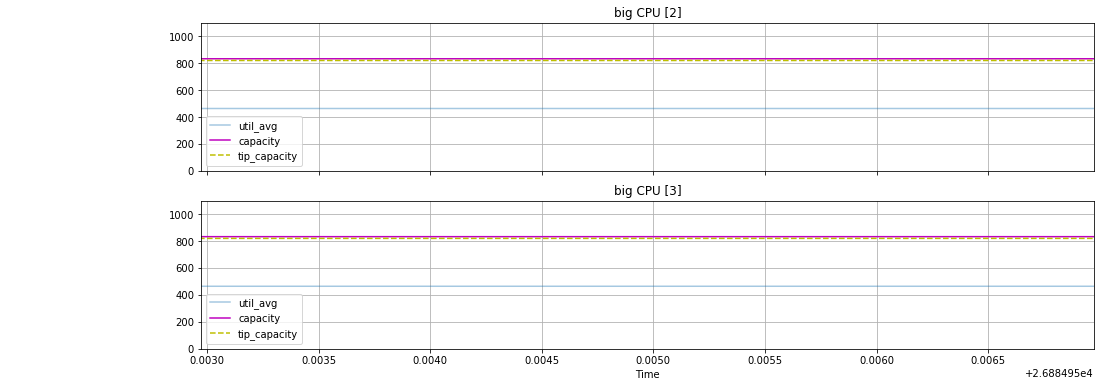

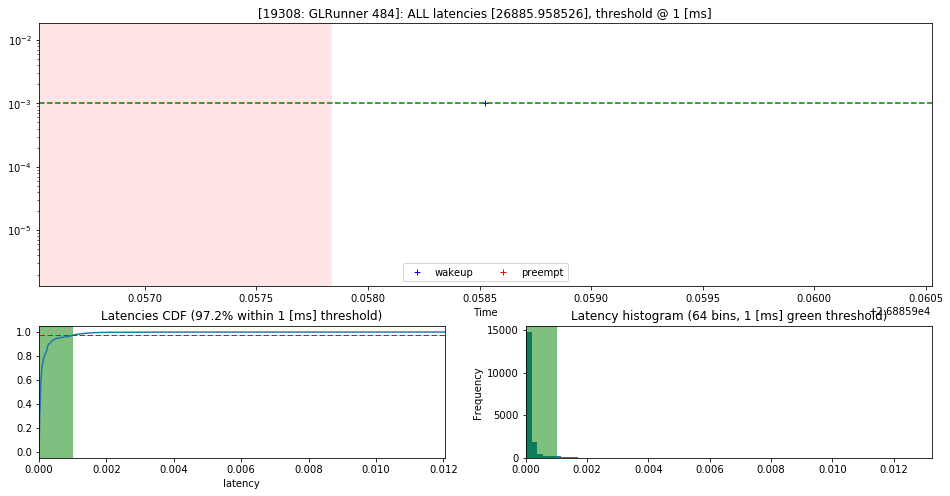

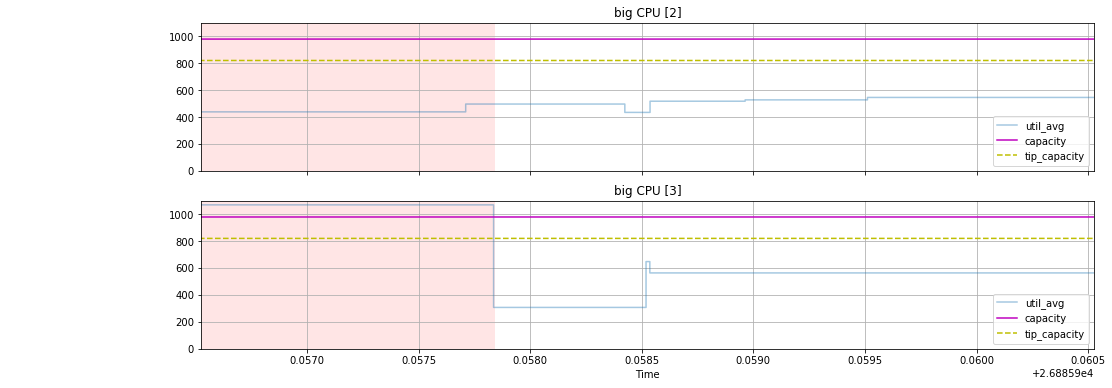

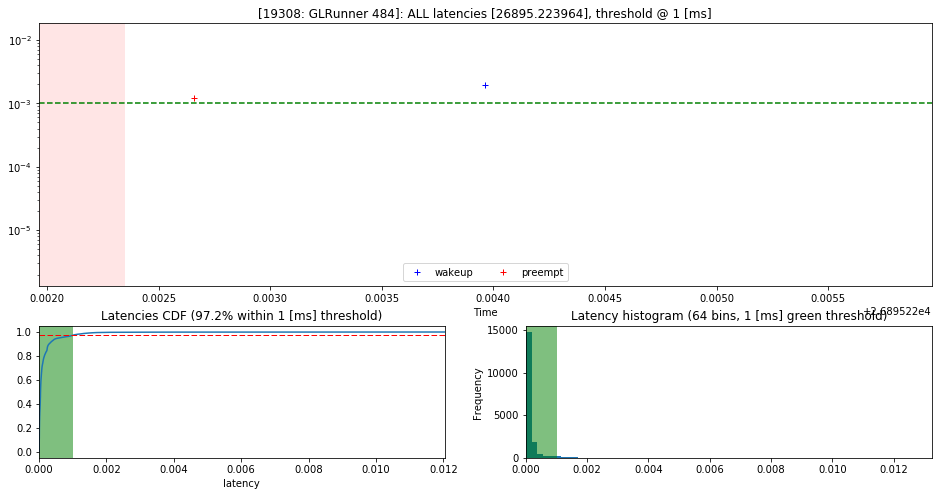

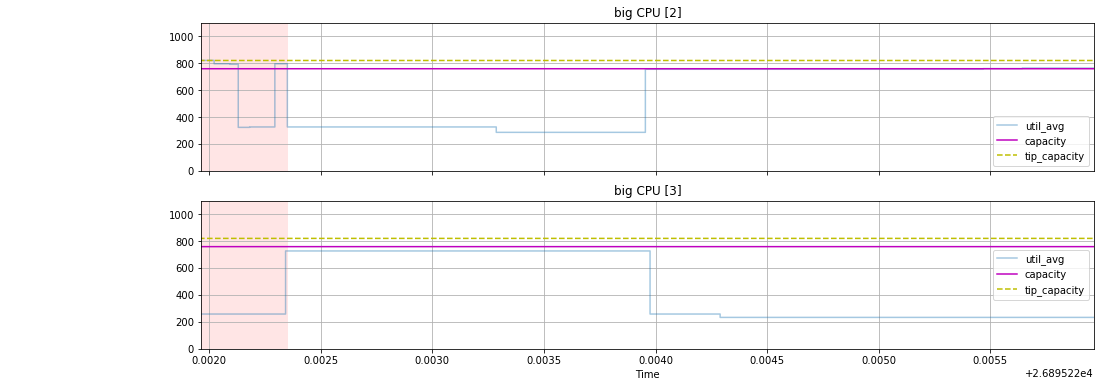

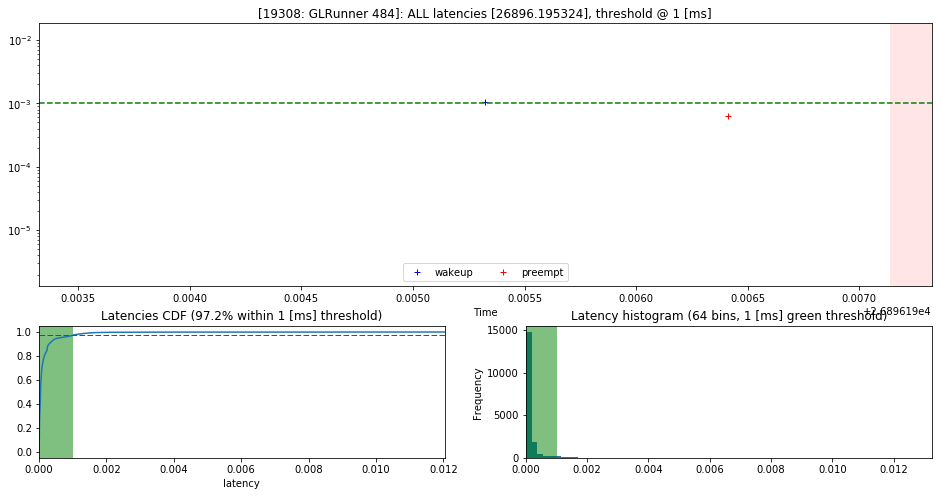

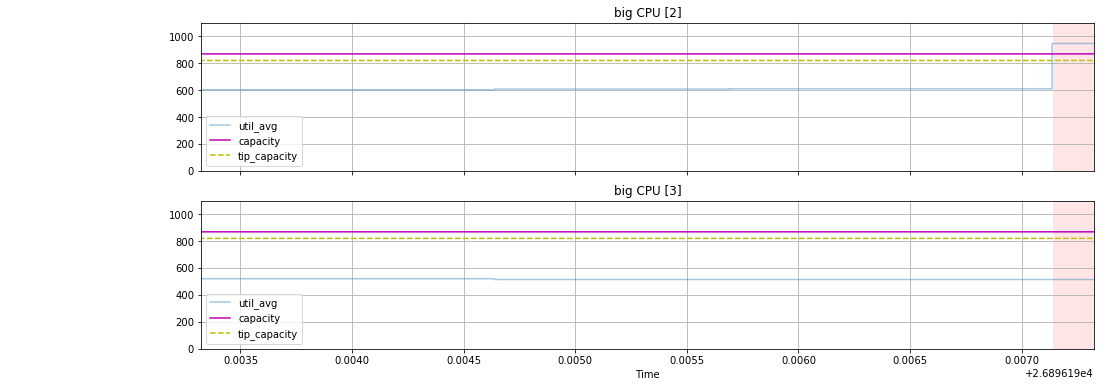

In [12]:
# Plot each EAS-induced latency (blue cross)
# If the background is red, system was over-utilized and the latency wasn't caused by EAS
for start, latency in eas_latencies:
    trace.setXTimeRange(start - 0.002, start + 0.002)
    trace.analysis.latency.plotLatency(task=glrunner["pid"], tag=str(start))
    trace.analysis.cpus.plotCPU(cpus=[2,3])

## Overall latencies

This plot displays the whole duration of the experiment, it can be used to see how often the system was overutilized or how much latency was involved.

2017-03-07 12:06:51,029 INFO    : Analysis     : Found:  2517 WAKEUP latencies
2017-03-07 12:06:51,069 INFO    : Analysis     : Found: 15435 PREEMPT latencies
2017-03-07 12:06:51,071 INFO    : Analysis     : Total: 17952 latency events
2017-03-07 12:06:51,075 INFO    : Analysis     : 97.2 % samples below 1 [ms] threshold


,latency
count,17952.000000
mean,0.000142
std,0.000341
min,0.000002
50%,0.000048
95%,0.000589
99%,0.001422
max,0.012042
97.2%,0.001000


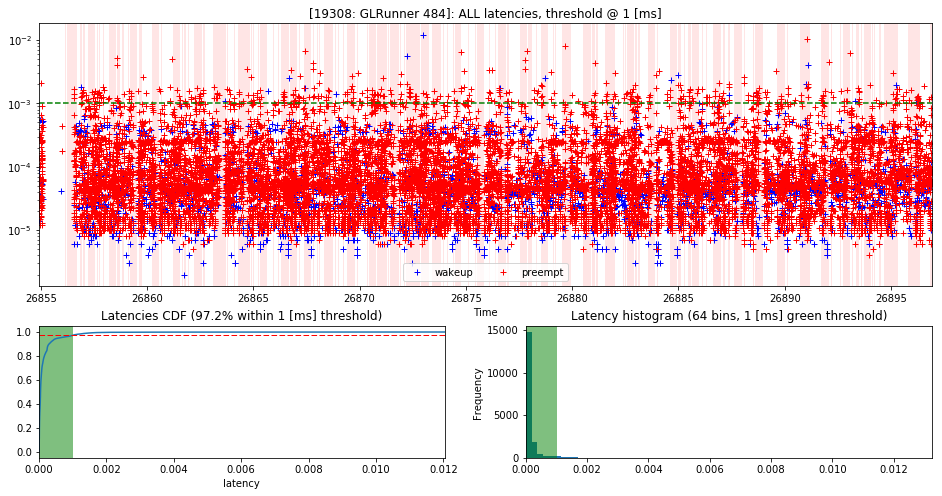

In [13]:
# Plots all of the latencies over the duration of the experiment
trace.setXTimeRange(trace.window[0] + 1, trace.window[1])
trace.analysis.latency.plotLatency(task=glrunner["pid"])

# Kernelshark analysis

In [15]:
!kernelshark {trace_file} 2>/dev/null

version = 6
